Dataset: For this datastory telling project I chose to use an old kaggle dataset which I am also using for my capstone. 
the data consists of two sets. One set represents bids that were made including information such as the time, merchandise 
and country.

***Describe the data, number of elements per category, size of data***

Number of unique values for each column of the bid data set

Column Name | # of unique values
----------- | ------------------
Total rows | 7656334
bidder_id | 6614
auction | 15051
merchandise | 10
device | 7351
time | 776529
country | 199
ip | 2303991
url | 1786351
f_time | 13274
diff_time | 1222836

Link to data: https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/data

Questions to ask:
The big overall question is, "What would distinguish a bot from a human"
Some of the questions we ask ourselves are,
- Do Bots tend to bid at a certain time after a bid has opened?
- Do they have more unique bids overall? (we would expect so)
- Are bots more likely to come from certain countries/ips/urls?
- Do bots tend to bid from more distinct devices, urls or IPs, etc?
- ***are there IPs/URLs that have significant number of bots/different users high percentages or low percentage bots***
We will explore some of these questions as well as similar ones and then see if further questions and plots should be examined.

In [2]:
#Importing and uploading data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bids = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/bids.csv')
train = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/train.csv')

#adding final time features created by subtracting bid time from the last time in the auction. 
test_df = pd.DataFrame.from_csv('C:/Users/Christopher Gardner/Documents/Python Scripts/final_times.csv')
test_df.columns = ['f_time']
bids = bids.merge(test_df, left_on='auction', right_index=True)
bids['diff_time'] = bids.f_time - bids.time

#create proper merge
groupfirst = bids.groupby(bids.bidder_id).nunique().sort_index()
mergedsecond = groupfirst.merge(train.sort_index(), left_index=True, right_index=True)

#now sort by desired values, update ranking and then split into bots and humans for plotting
mergedsecond = mergedsecond.sort_values(by=['auction'])
mergedsecond['ranking'] = np.arange(len(mergedsecond))
bots = mergedsecond[mergedsecond.outcome==1]
humans = mergedsecond[mergedsecond.outcome==0]
mergedsecond.head()

#mergefirst
mergedfirst = bids.merge(train, left_on='bidder_id', right_index=True)
groupedsecond = mergedfirst.groupby('bidder_id').nunique()

Do Bots tend to bid at a certain time after a bid has opened?

    A new feature called diff_time was created in the data set which calculates the final time of each bid and then subtracts 
from it the time of the bid. This normalizes the data and puts it in the form of "Time before the end of the bid". Comparing histograms of this diff_time feature for the bots and humans side by side shows that the distributions are very similar which may mean that using the diff_time feature may not be useful for determining is something is a bot. This is odd because you would expect that bots would be more likely to bid at either end. On closer inspection you may be able to say something about the shaper peaks for humans as diff_time approaches 0 (ending of the bid) and that the bots tend to have a sharper cutoff for bidding right after the bid opens. It may be possible to gather more insights from this feature with different visualizations.

In [41]:
#function for showing hists between bots and humans
def Hist(s, l):
    '''str argument is the column value to be evaluated
        l sets the max range'''
    plt.subplot(211)
    plt.title('Frequency of bidders using different {}s'.format(s)) 
    plt.hist(bots[s], color='b', range=(0,l), bins=100)
    plt.legend('Bots')
    plt.subplot(212)
    plt.hist(humans[s], color='r', range=(0,l), bins=100)
    plt.legend('Humans')
    plt.xlabel('Number of different {}s'.format(s))
    plt.ylabel('Number of Bidders')
    plt.show()
    

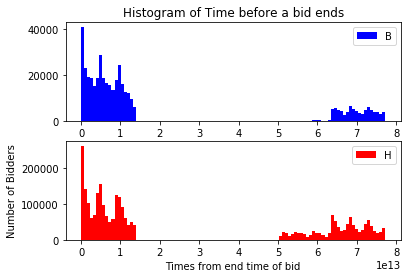

In [32]:
plt.subplot(211)
plt.title('Histogram of Time before a bid ends')
plt.hist(mergedfirst.diff_time[mergedfirst.outcome==1], color='b', bins=100)
plt.legend('Bots')
plt.subplot(212)
plt.hist(mergedfirst.diff_time[mergedfirst.outcome==0], color='r', bins=100)
plt.legend('Humans')
plt.xlabel('Times from end time of bid')
plt.ylabel('Number of Bidders')
plt.show()

Do they have more unique bids overall? (we would expect so)
    
   We would expect that since bots non-human entities they would be able to bid in more auctions and also bid more often than
their human counter parts. Comparisons of histograms between bots and humans show us that we would be correct to assume this.
In both the plots below, the bot distributions have a slower fall off than the humans which show us that bidders with higher bid 
counts and those who bid in more distinct auctions are more likely to be bots. 

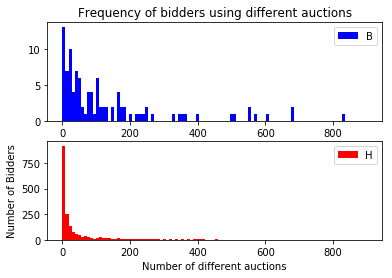

In [42]:
Hist('auction', 900)

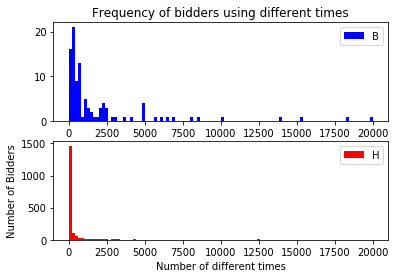

In [43]:
Hist('time', 20000)

Do bots tend to bid from more distinct devices, urls or IPs, etc?

   Similar to distinct number of bids we would think that bots are also able to spoof multiple different devices or IPs. 
The histograms below show that bots tend to have higher distinct IP and devices counts than humans. The Url histogram is
very interesting and while it also shows that bots tend to have a higher distinct url count than humans but also that there is
a huge spike at the low counts. This may be possible if bots favor certain URLs over others.

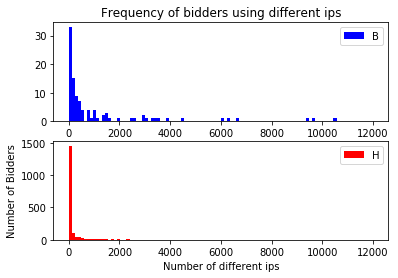

In [45]:
Hist('ip', 12000)

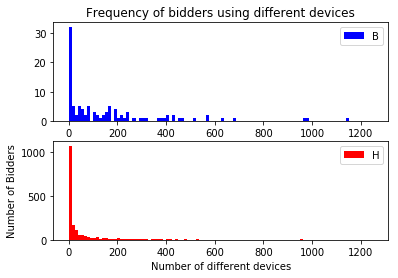

In [46]:
Hist('device', 1250)

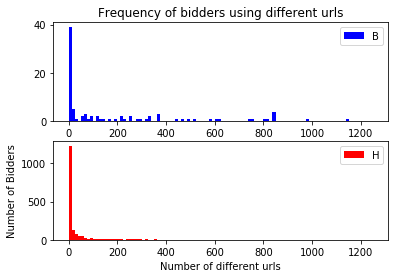

In [47]:
Hist('url', 1250)

In [ ]:
Are bots more likely to be from certain countries, ips or urls?

From the stacked barchart its easy to see that there are certainly countries where a higher percentage of bots. These 
high bot percent countries should be examined more closely at total bidders to make sure that the data is actually significant.
For example maybe a 60% bot filled countries is only from 3 bidders in which case it may not be a statistically significant trend.
Stacked bar charts were not feasible for examining URLs and IPs because they had too many unique values. By truncating the amount
of IPs or URLs by the number of bids coming we can get an idea of the trends that are occuring with these sets. From these plots
we can see that high bid count IPs do not seem that useful for looking for bots but 

In [51]:
#Function for creating stacked bar charts
def stacked_bar(df, str):
    '''stacked_bar(df, str)
    takes a string that is a column name and creates a stacked bar chart from column str in dataframe df'''
    hu_count = df[df.outcome ==0].groupby(str).count().bidder_id
    bot_count = df[df.outcome ==1].groupby(str).count().bidder_id
    total = hu_count + bot_count
    hu_count = (hu_count/total).sort_values()
    bot_count = (bot_count/total).sort_values(ascending =False)
    inds = np.arange(len(hu_count))
    plt.title('')
    plt.xlabel(str)
    plt.ylabel('Percentage of bots per ' + str)
    plt.bar(inds, bot_count)
    plt.bar(inds, hu_count, bottom=bot_count)
    plt.show()

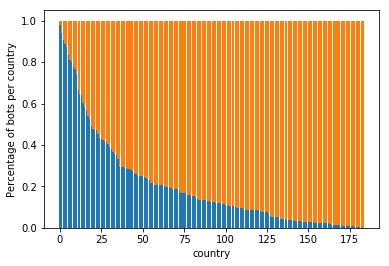

In [52]:
stacked_bar(mergedfirst, 'country')

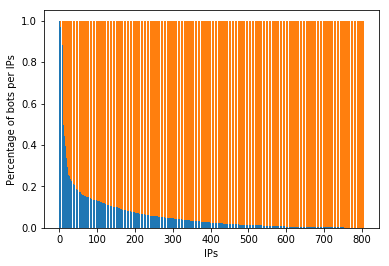

In [3]:
thres = mergedfirst.groupby('ip').count() > 300
df = mergedfirst.merge(thres, left_on='ip', right_index=True)
df = df[df.bidder_id_y == True]
hu_count = df[df.outcome_x ==0].groupby('ip').count().sort_index()
bot_count = df[df.outcome_x ==1].groupby('ip').count().sort_index()
total = hu_count + bot_count
hu_count = (hu_count/total).sort_values('bidder_id_x')
bot_count = (bot_count/total).sort_values('bidder_id_x', ascending=False)
inds = np.arange(len(hu_count))
plt.title('')
plt.xlabel('IPs')
plt.ylabel('Percentage of bots per IPs')
plt.bar(inds, bot_count.bidder_id_x)
plt.bar(inds,hu_count.bidder_id_x, bottom=bot_count.bidder_id_x)
plt.show()

In [80]:
url_thres = mergedfirst.groupby('url').count() > 300
url_df = mergedfirst.merge(url_thres, left_on='url', right_index=True)
url_df = url_df[url_df.bidder_id_y == True]

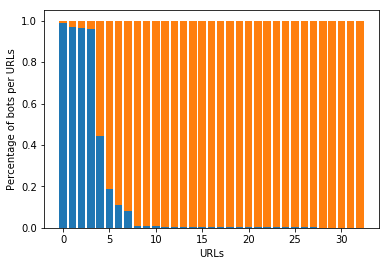

In [29]:
url_thres = mergedfirst.groupby('url').count() > 300
url_df = mergedfirst.merge(url_thres, left_on='url', right_index=True)
url_df = url_df[url_df.bidder_id_y == True]
url_hu_count = url_df[url_df.outcome_x ==0].groupby('url').count().sort_index()
url_bot_count = url_df[url_df.outcome_x ==1].groupby('url').count().sort_index()
total = url_hu_count + url_bot_count
url_hu_count = (url_hu_count/total).sort_values('bidder_id_x')
url_bot_count = (url_bot_count/total).sort_values('bidder_id_x', ascending=False)
inds = np.arange(len(url_hu_count))
plt.title('')
plt.xlabel('URLs')
plt.ylabel('Percentage of bots per URLs')
plt.bar(inds, url_bot_count.bidder_id_x)
plt.bar(inds,url_hu_count.bidder_id_x, bottom=url_bot_count.bidder_id_x)
plt.show()

Conclusions:

As we have shown throught this graphical analysis of the data there are several categories which seem to correlate to a bidder being a bot. Some of these categories are number of unique bids, number of bids from unique IPs, number of unique URLs and number of unique auctions entered. Stacked bar chart visualizations show us also that certain countries and URLs may be bot hotspots and a user who is from these countries or bids through these URLs has a higher chance of being a bot. These graphical representations also bring up other interesting questions to ask such "Is the bid/auction ration important" and "From the high % countries and urls are they significant or is it a low sample size" 
